In [1]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import BaseEstimator
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [2]:
!pip install image-classifiers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from classification_models.keras import Classifiers

ResNet34, preprocess_resnet34 = Classifiers.get('resnet34')

In [4]:
def set_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
BASE_INPUT_DIR = './input/'
TRAIN_INPUT_DIR = os.path.join(BASE_INPUT_DIR, 'melspec-img')
TEST_INPUT_DIR = os.path.join(BASE_INPUT_DIR, 'rfcx-species-audio-detection/test')

In [6]:
train_tp = pd.read_csv(os.path.join(BASE_INPUT_DIR, 'rfcx-species-audio-detection/train_tp.csv'))
submission = pd.read_csv(os.path.join(BASE_INPUT_DIR, 'rfcx-species-audio-detection/sample_submission.csv'))

# Custom Metrics & Loss

In [7]:
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example
    y_true = tf.cast(y_true > 0, dtype=tf.int32)

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense


class LWLRAP(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

In [8]:
def get_lsep_loss(num_classes, weights_list=None):
    if weights_list is None:
        weights_list = np.ones(num_classes, dtype=np.float32)
    
    @tf.function
    def lsep_loss(y_true, y_pred):
        batch_size = tf.math.floordiv(K.sum(K.exp(y_true - y_true)), num_classes)
        
        y_t = K.reshape(y_true, (batch_size, num_classes))
        y_p = K.reshape(y_pred, (batch_size, num_classes))
        M_unit = tf.ones((batch_size, num_classes)) 
        M1 = (M_unit - y_t) * K.reshape(K.tile(weights_list, [batch_size]), (batch_size, num_classes))
       
        M_pairwise = tf.einsum('ij,ik->ijk', M1, y_t)    # shape = (batch_size, num_classes, num_classes)
        M_large = tf.einsum('ij,ik->ijk', M_unit, y_p)  # shape = (batch_size, num_classes, num_classes)

        M_diff = K.exp(K.permute_dimensions(M_large, (0, 2, 1)) - M_large)  # shape = (batch_size, num_classes, num_classes)
        M = M_pairwise * M_diff  # shape = (batch_size, num_classes, num_classes)

        return K.mean(K.log(1 + K.sum(K.sum(M, 2), 1)))
    
    return lsep_loss

# Constants & Configs

In [9]:
NUM_SPECIES = 24

IMG_SIZE = (224, 512, 3)
IMG_HEIGHT = IMG_SIZE[0]
IMG_WIDTH = IMG_SIZE[1]

FMIN = 40.0
FMAX = 24000.0

SR = 48000
N_MELS = 224
N_FRAMES = 559

CLIP_DURATION = 60
SEGMENT_DURATION = 10

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

cfg = {
    'preprocess': {
        'frame_size': 2048,
        'hop_length': 512,
        'sub_segment_duration': 6,

        'spec_aug_prob': 0.7,
        'spec_aug_erase_time': 50,
        'spec_aug_erase_mel': 16,
        'spec_aug_num_time_cuts': 2,
        'spec_aug_num_freq_cuts': 4,
        
        'gauss_noise_prob': 0.7,
        'gauss_noise_std': 0.5,
        
        'random_brightness': 0.3,
        
        'do_mixup': True,
        'mixup_alpha': 0.2,
    },
    'training': {
        'use_tpu': False,
        'n_folds': 5,
        'batch_size': 32,
        'shuffle_buffer_size': 2000,
        'steps_per_epoch': 64,

        'frozen_learning_rate': 1e-2,
        'num_unfreeze_layers': None,

        'learning_rate': 1e-4,
        'min_lr': 1e-7,
    },
    'model': {
        'backbone_arch': 'resnet50',  # effnet_b0, effnet_b1, resnet50, resnet34
        'backbone_preprocess': keras.applications.resnet.preprocess_input,
    },
    'inference': {
        'segment_stride': 3
    }
}

In [11]:
tpu_strategy = None

if cfg['training']['use_tpu']:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Preprocessing

In [12]:
feature_description = {
    'idx': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'cut_tmin': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'windows': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'species': tf.io.FixedLenFeature([], tf.string, default_value=''),
}


@tf.function
def _parse_input_tfrec(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    return {
        'idx': tf.io.parse_tensor(sample['idx'], tf.int32),
        'audio_wav': tf.io.parse_tensor(sample['audio_wav'], tf.float32),
        'recording_id': tf.io.parse_tensor(sample['recording_id'], tf.string),
        'cut_tmin': tf.io.parse_tensor(sample['cut_tmin'], tf.float32),
        'windows': tf.io.parse_tensor(sample['windows'], tf.float32),
        'species': tf.io.parse_tensor(sample['species'], tf.int32),
    }


@tf.function
def _cut_wav(x, samples, is_train):
    idx = x['idx']
    cut_tmin = x['cut_tmin']
    main_spid, main_tmin, main_tmax = samples[idx, 0], samples[idx, 1], samples[idx, 2]
    main_spid = tf.cast(main_spid, tf.int32)
    main_tmin = tf.cast(main_tmin, tf.float32)
    main_tmax = tf.cast(main_tmax, tf.float32)
    main_tmin -= cut_tmin
    main_tmax -= cut_tmin
    sub_segment_duration = cfg['preprocess']['sub_segment_duration']
    
    if is_train:
        if main_tmax - main_tmin < sub_segment_duration:
            min_left = tf.maximum(0.0, main_tmax - sub_segment_duration)
            max_left = tf.minimum(main_tmin, SEGMENT_DURATION - sub_segment_duration)
        else:
            shrinkage = (main_tmax - main_tmin) - sub_segment_duration
            min_left = main_tmin
            max_left = main_tmin + shrinkage
        left_cut = tf.random.uniform([], minval=min_left, maxval=max_left)
    else:
        if main_tmax - main_tmin < sub_segment_duration:
            extension = tf.maximum(0.0, sub_segment_duration - (main_tmax - main_tmin))/2
            left_extend = extension
            if main_tmax + extension > SEGMENT_DURATION:
                left_extend += main_tmax + extension - SEGMENT_DURATION
            left_cut = tf.maximum(0.0, main_tmin - left_extend)
        else:
            shrinkage = (main_tmax - main_tmin) - sub_segment_duration
            left_cut = main_tmin + shrinkage/2
    
    left_cut_sample = tf.cast(tf.floor(left_cut * SR), tf.int32)
    right_cut_sample = left_cut_sample + sub_segment_duration*SR
    x = x.copy()
    x['audio_wav'] = tf.reshape(x['audio_wav'][left_cut_sample:right_cut_sample], [sub_segment_duration*SR])
    x['windows'] = [[main_tmin, main_tmax]]
    x['species'] = [main_spid]
    
    return x


@tf.function
def _wav_to_mel_spec(x):
    frame_size = cfg['preprocess']['frame_size']
    hop_length = cfg['preprocess']['hop_length']
    
    stfts = tf.signal.stft(
        x["audio_wav"],
        frame_length=frame_size,
        frame_step=hop_length,
        fft_length=frame_size,
        window_fn=tf.signal.hann_window,
    )
    hz_spec = tf.square(tf.abs(stfts))

    n_hz_spec_bins = tf.shape(stfts)[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(N_MELS, n_hz_spec_bins, SR, FMIN, FMAX)
    mel_spec = tf.tensordot(hz_spec, linear_to_mel_weight_matrix, 1)
    mel_spec.set_shape(hz_spec.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spec = tf.math.log(mel_spec + 1e-6)/tf.math.log(10.0)

    y = {
        'mel_spec': tf.transpose(log_mel_spec)
    }
    y.update(x)
    return y


@tf.function
def _create_labels(x):
    species, _ = tf.unique(tf.cast(x['species'], dtype=tf.int64))
    species = tf.sort(species)
    n_labels = tf.shape(species)[0]
    species = tf.reshape(species, (-1, 1))
    return tf.sparse.to_dense(tf.sparse.SparseTensor(species, tf.ones([tf.shape(species)[0]]), [NUM_SPECIES]))


def _create_idx_filter(indices):
    @tf.function
    def _filter_func(x):
        return tf.reduce_any(indices == x['idx'])
    return _filter_func


def _filter_indices(dataset, indices):
    return dataset.filter(_create_idx_filter(indices))


@tf.function
def augment_img(image):
    
    @tf.function
    def _specaugment(image):
        erase_time = cfg['preprocess']['spec_aug_erase_time']
        erase_mel = cfg['preprocess']['spec_aug_erase_mel']
        num_time_cuts = cfg['preprocess']['spec_aug_num_time_cuts']
        num_freq_cuts = cfg['preprocess']['spec_aug_num_freq_cuts']
        img_height = tf.shape(image)[0]
        img_width = tf.shape(image)[1]
        image = tf.expand_dims(image, axis=0)

        xoff = tf.random.uniform([num_time_cuts], minval=erase_time//2, maxval=img_width - erase_time//2, dtype=tf.int32)
        xsize = tf.random.uniform([num_time_cuts], minval=erase_time//2, maxval=erase_time, dtype=tf.int32)
        yoff = tf.random.uniform([num_freq_cuts], minval=erase_mel//2, maxval=img_height-erase_mel//2, dtype=tf.int32)
        ysize = tf.random.uniform([num_freq_cuts], minval=erase_mel//2, maxval=erase_mel, dtype=tf.int32)

        for i in range(num_time_cuts):
            image = tfa.image.cutout(image, [img_height, xsize[i]], offset=[img_height//2, xoff[i]])
        for i in range(num_freq_cuts):
            image = tfa.image.cutout(image, [ysize[i], img_width], offset=[yoff[i], img_width//2])

        image = tf.squeeze(image, axis=0)
        return image
    
    gauss_noise = tf.keras.layers.GaussianNoise(cfg['preprocess']['gauss_noise_std']) 
    image = tf.cond(
        tf.random.uniform([]) < cfg['preprocess']['gauss_noise_prob'],
        lambda: gauss_noise(image, training=True), lambda: image
    )
    image = tf.image.random_brightness(image, cfg['preprocess']['random_brightness'])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cond(
        tf.random.uniform([]) < cfg['preprocess']['spec_aug_prob'],
        lambda: _specaugment(image), lambda: image
    )

    return image


@tf.function
def _mixup(inp, targ):
    indices = tf.range(len(inp))
    indices = tf.random.shuffle(indices)
    sinp = tf.gather(inp, indices, axis=0)
    starg = tf.gather(targ, indices, axis=0)

    alpha = cfg['preprocess']['mixup_alpha']
    t = tf.compat.v1.distributions.Beta(alpha, alpha).sample([len(inp)])
    tx = tf.reshape(t, [-1, 1, 1, 1])
    ty = tf.reshape(t, [-1, 1])
    x = inp * tx + sinp * (1 - tx)
    y = targ * ty + starg * (1 - ty)
    return x, y


@tf.function
def preprocess_img(img, is_train):
    img.set_shape([N_MELS, N_FRAMES])
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.resize(img, IMG_SIZE[:-1])
    img = tf.image.per_image_standardization(img)
    if is_train:
        img = augment_img(img)
    img_min = tf.reduce_min(img)
    img_max = tf.reduce_max(img)
    img = (img - img_min)/(img_max - img_min)*255
    img = tf.image.grayscale_to_rgb(img)
    return img


def build_dataset(indices, samples, is_train):
    
    @tf.function
    def _split_img_label(x):
        return x['mel_spec'], _create_labels(x)
    
    @tf.function
    def _cut_sub_segment(x):
        return _cut_wav(x, samples, is_train)
    
    samples = samples[['species_id', 't_min', 't_max']].values
    filepath = os.path.join(TRAIN_INPUT_DIR, 'train.cut_audio.tfrecord')
    ds = tf.data.TFRecordDataset(filepath)
    ds = ds.map(_parse_input_tfrec, num_parallel_calls=AUTOTUNE)
    ds = _filter_indices(ds, indices)
    ds = ds.cache()
    if is_train:
        ds = ds.shuffle(buffer_size=cfg['training']['shuffle_buffer_size'])
        ds = ds.repeat()
    ds = ds.map(_cut_sub_segment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(_wav_to_mel_spec, num_parallel_calls=AUTOTUNE)
    ds = ds.map(_split_img_label, num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda img, l: (preprocess_img(img, is_train), l), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(cfg['training']['batch_size'])
    if is_train and cfg['preprocess']['do_mixup']:
        ds = ds.map(_mixup, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

# Model

In [13]:
class ModelNN(BaseEstimator):
    
    def __init__(
        self,
        n_classes=NUM_SPECIES,
        backbone_arch=cfg['model']['backbone_arch'],
    ):
        self.n_classes = n_classes
        self.backbone_arch = backbone_arch
        self.estimator_ = None
        
    def compile_model(self, model, is_frozen):
        if is_frozen:
            learning_rate = cfg['training']['frozen_learning_rate']
        else:
            learning_rate = cfg['training']['learning_rate']
            
        lr_schedule = tf.keras.experimental.CosineDecayRestarts(
            learning_rate, 1500, t_mul=2.0, m_mul=0.5, alpha=1e-8, name='consine_decay'
        )
        model.compile(
#             optimizer=tfa.optimizers.RectifiedAdam(learning_rate=learning_rate),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=get_lsep_loss(NUM_SPECIES),
            metrics=[LWLRAP(self.n_classes), keras.metrics.AUC(multi_label=True, name='auc'), 'accuracy']
        )
        return model
        
    def build_model(self, freeze_backbone):
        inputs = keras.layers.Input(shape=IMG_SIZE)

        if self.backbone_arch == 'effnet_b0':
            model_backbone = keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs)
        elif self.backbone_arch == 'effnet_b1':
            model_backbone = keras.applications.EfficientNetB1(include_top=False, input_tensor=inputs)
        elif self.backbone_arch == 'resnet50':
            model_backbone = keras.applications.ResNet50(include_top=False, input_tensor=inputs)
        elif self.backbone_arch == 'resnet34':
            model_backbone = ResNet34(include_top=False, input_tensor=inputs, weights='imagenet')
        else:
            raise Exception(f'Unsupported backbone arch: {self.backbone_arch}')
            
        if freeze_backbone:
            model_backbone.trainable = False
        
        x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model_backbone.output)
        x = keras.layers.BatchNormalization()(x)

        top_dropout_rate = 0.4
        x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        outputs = tfa.layers.WeightNormalization(keras.layers.Dense(self.n_classes, activation='sigmoid'), name="pred")(x)

        model = keras.Model(inputs, outputs, name="EfficientNet")
        return self.compile_model(model, freeze_backbone)
    
    def unfreeze_backbone(self, num_layers=cfg['training']['num_unfreeze_layers']):
        model = self.estimator_
        selected_layers = model.layers[-num_layers:] if num_layers is not None else model.layers
        for layer in selected_layers:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
        self.estimator_ = self.compile_model(model, False)
  
    def fit(self, train_dataset, val_dataset, n_epochs=25, weights_suffix='', with_callbacks=True):
        if self.estimator_ is None:
            if cfg['training']['use_tpu']:
                with tpu_strategy.scope():
                    self.estimator_ = self.build_model(freeze_backbone=True)
            else:
                self.estimator_ = self.build_model(freeze_backbone=True)
        
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            f'./weights{weights_suffix}.h5',
            monitor='val_lwlrap',
            save_best_only=True,
            save_weights_only=True,
            mode='max'
        )
        lr_scheduler = keras.callbacks.ReduceLROnPlateau(
            monitor='val_lwlrap',
            patience=5,
            mode='max',
            min_lr=cfg['training']['min_lr'],
            verbose=2
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_lwlrap',
            patience=15,
            mode='max',
            restore_best_weights=True
        )
        logs_cb = tf.keras.callbacks.CSVLogger(f'logs/metrics{weights_suffix}.csv')
#         callbacks = [model_checkpoint, lr_scheduler, early_stopping, logs_cb]
        callbacks = [model_checkpoint, early_stopping, logs_cb]

        return self.estimator_.fit(
            train_dataset,
            epochs=n_epochs,
            callbacks=callbacks if with_callbacks else None,
            validation_data=val_dataset,
            steps_per_epoch=cfg['training']['steps_per_epoch'],
            verbose=2
        )
    
    def predict(self, img):
        return self.estimator_.predict(img)
    
    def load_weights(self, checkpoint_path):
        if self.estimator_ is None:
            self.estimator_ = self.build_model(freeze_backbone=False)
            self.unfreeze_backbone()
        self.estimator_.load_weights(checkpoint_path)

In [14]:
def print_val_metrics(history):
    max_idx = np.argmax(history.history['val_lwlrap'])
    print(
        history.history['val_lwlrap'][max_idx],
        history.history['val_auc'][max_idx],
        history.history['val_accuracy'][max_idx],
    )

In [15]:
samples = train_tp.copy()
targets = train_tp['species_id'].copy()

In [16]:
skf = StratifiedKFold(n_splits=cfg['training']['n_folds'])
random_seeds = [398, 182, 718, 580, 403]
val_lwraps = []
histories = []
print('Configs:', cfg)

for fold, (train_idx, val_idx) in enumerate(skf.split(samples, targets)):
    K.clear_session()
    set_random_seeds(random_seeds[fold])

    train_dataset = build_dataset(train_idx, samples, is_train=True)
    val_dataset = build_dataset(val_idx, samples, is_train=False)

    model = ModelNN()
    
    print(f'* [{fold}] Train with frozen backbone')
    history = model.fit(train_dataset, val_dataset, n_epochs=10, weights_suffix=f'_{fold}_pretrained')
    print_val_metrics(history)
    
    print(f'** [{fold}] Train with full model')
    model.load_weights(f'./weights_{fold}_pretrained.h5')
    model.unfreeze_backbone()
    history = model.fit(train_dataset, val_dataset, n_epochs=100, weights_suffix=f'_{fold}_final')

    val_lwrap = max(history.history['val_lwlrap'])
    val_lwraps.append(val_lwrap)
    histories.append(history)
    print_val_metrics(history)
    
print('*** Avg val lwrap:', np.mean(val_lwraps), 'Std:', np.std(val_lwraps))

Configs: {'preprocess': {'frame_size': 2048, 'hop_length': 512, 'sub_segment_duration': 6, 'spec_aug_prob': 0.7, 'spec_aug_erase_time': 50, 'spec_aug_erase_mel': 16, 'spec_aug_num_time_cuts': 2, 'spec_aug_num_freq_cuts': 4, 'gauss_noise_prob': 0.7, 'gauss_noise_std': 0.5, 'random_brightness': 0.3, 'do_mixup': True, 'mixup_alpha': 0.2}, 'training': {'use_tpu': False, 'n_folds': 5, 'batch_size': 32, 'shuffle_buffer_size': 2000, 'steps_per_epoch': 64, 'frozen_learning_rate': 0.01, 'num_unfreeze_layers': None, 'learning_rate': 0.0001, 'min_lr': 1e-07}, 'model': {'backbone_arch': 'resnet50', 'backbone_preprocess': <function preprocess_input at 0x7f0e2ce33170>}, 'inference': {'segment_stride': 3}}
* [0] Train with frozen backbone
94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/10
64/64 - 58s - loss: 3.0221 - lwlrap: 0.2766 - auc: 0.6085 - accuracy: 0.1367 - val_loss: 2.9317 - val_lwlrap: 0.3716 - val_auc: 0.8114 - val_accuracy: 0.1926
Epoch 2/10
64/64 - 55s - loss: 2

In [17]:
!zip weights.zip ./weights_*_final.h5
!gsutil cp ./weights.zip gs://tn-kaggle-data/

  adding: weights_0_final.h5 (deflated 8%)
  adding: weights_1_final.h5 (deflated 8%)
  adding: weights_2_final.h5 (deflated 8%)
  adding: weights_3_final.h5 (deflated 8%)
  adding: weights_4_final.h5 (deflated 8%)
Copying file://./weights.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][419.5 MiB/419.5 MiB]    

In [26]:
def plot_history(history, ax=None):
    lwlrap = history.history['lwlrap']
    val_lwlrap = history.history['val_lwlrap']
    df = pd.DataFrame({'train': lwlrap, 'val': val_lwlrap})
    df.plot(ax=ax)

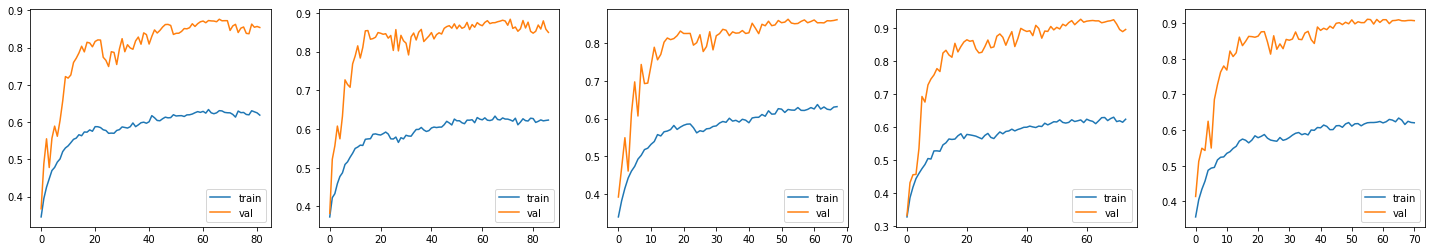

In [27]:
_ = plt.figure(figsize=(25, 4))
for i, history in enumerate(histories):
    ax = plt.subplot(1, len(histories), i + 1)
    plot_history(history, ax=ax)

# Inference

In [20]:
RUN_INFERENCE = False

In [21]:
def load_audio(recording_id, train=True):
    filepath = os.path.join(TRAIN_INPUT_DIR if train else TEST_INPUT_DIR, recording_id + '.flac')
    data, _ = librosa.load(filepath, sr=SR)
    return data


def cut_audio(audio_data, tmin, tmax, sr=SR, segment_duration=SEGMENT_DURATION):
    clip_duration = len(audio_data)/sr
    extra_time = max(0, segment_duration - (tmax - tmin)) / 2
    tmin = max(0, tmin - extra_time)
    tmax = min(clip_duration, tmax + extra_time)

    min_sample, max_sample = librosa.time_to_samples([tmin, tmax], sr=sr)
    return audio_data[min_sample:(max_sample + 1)]
    

def get_mel_spec_img(audio_data):
    mel_spec = librosa.feature.melspectrogram(audio_data, sr=SR, n_mels=N_MELS)
    log_mel_spec = librosa.power_to_db(mel_spec)
    img = tf.expand_dims(log_mel_spec, -1)
    img = tf.image.resize(img, IMG_SIZE[:2])
    img = tf.image.per_image_standardization(img)
    return img, log_mel_spec


def cut_and_get_mel_spec_img(audio_data, t_min, t_max):
    audio_data = cut_audio(audio_data, t_min, t_max)
    return get_mel_spec_img(audio_data)

In [22]:
def predict(model, recording_id):
    audio_data = load_audio(recording_id, train=False)
    imgs = []
    for t_min in range(0, 55, cfg['inference']['segment_stride']):
        t_max = t_min + SEGMENT_DURATION
        img, _ = cut_and_get_mel_spec_img(audio_data, t_min, t_max)
        img = preprocess_img(img, False)
        imgs.append(img)
    preds = model.predict(tf.stack(imgs))
    return tf.reduce_max(preds, axis=0)

In [23]:
if RUN_INFERENCE:
    model = ModelNN()
    model.load_weights('./weights.h5')
    preds = predict(model, submission['recording_id'][0])
    submission.iloc[0, 1:] = preds.numpy()
    submission.to_csv('./submission.csv', index=False)